## Indexing

In [1]:
cd /home/rakesh/Downloads/Evertz/WeatherRAG

/home/rakesh/Downloads/Evertz/WeatherRAG


/home/rakesh/Downloads/Evertz/WeatherRAG/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import torch
import time
import os
from api_keys import GROQ_API_KEY, TAVILY_API_KEY
from transformers import AutoTokenizer, AutoModel
from langchain_core.documents import Document
from langchain_elasticsearch import ElasticsearchStore
from langchain_groq import ChatGroq
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_community.tools import TavilySearchResults
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

/home/rakesh/Downloads/Evertz/WeatherRAG/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rakesh/Downloads/Evertz/WeatherRAG/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [4]:
data = pd.read_excel('data/data.xlsx')
data

,city,temperature,weather,climate
0,New York,22,sunny,temperate
1,Los Angeles,25,partly cloudy,mediterranean
2,Chicago,18,cloudy,continental
3,Houston,30,thunderstorms,humid subtropical
4,Phoenix,35,sunny,desert
5,Toronto,20,partly cloudy,continental
6,Warsaw,16,overcast,temperate
7,Bangalore,28,rainy,tropical savanna
8,London,18,drizzle,temperate maritime
9,Paris,21,partly sunny,temperate


In [5]:
data['weather_climate_desc'] = data.apply(lambda row: f"Weather is {row['weather']} and Climate is {row['climate']}", axis=1)
data

,city,temperature,weather,climate,weather_climate_desc
0,New York,22,sunny,temperate,Weather is sunny and Climate is temperate
1,Los Angeles,25,partly cloudy,mediterranean,Weather is partly cloudy and Climate is medite...
2,Chicago,18,cloudy,continental,Weather is cloudy and Climate is continental
3,Houston,30,thunderstorms,humid subtropical,Weather is thunderstorms and Climate is humid ...
4,Phoenix,35,sunny,desert,Weather is sunny and Climate is desert
5,Toronto,20,partly cloudy,continental,Weather is partly cloudy and Climate is contin...
6,Warsaw,16,overcast,temperate,Weather is overcast and Climate is temperate
7,Bangalore,28,rainy,tropical savanna,Weather is rainy and Climate is tropical savanna
8,London,18,drizzle,temperate maritime,Weather is drizzle and Climate is temperate ma...
9,Paris,21,partly sunny,temperate,Weather is partly sunny and Climate is temperate


In [6]:
docs = []
for i, row in data.iterrows():
    doc = Document(page_content=row['weather_climate_desc'], metadata={'city': row['city'], 'temperature': row['temperature'],
                                                                       'weather': row['weather'], 'climate': row['climate']})
    docs.append(doc)

In [7]:
docs

[Document(metadata={'city': 'New York', 'temperature': 22, 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
 Document(metadata={'city': 'Los Angeles', 'temperature': 25, 'weather': 'partly cloudy', 'climate': 'mediterranean'}, page_content='Weather is partly cloudy and Climate is mediterranean'),
 Document(metadata={'city': 'Chicago', 'temperature': 18, 'weather': 'cloudy', 'climate': 'continental'}, page_content='Weather is cloudy and Climate is continental'),
 Document(metadata={'city': 'Houston', 'temperature': 30, 'weather': 'thunderstorms', 'climate': 'humid subtropical'}, page_content='Weather is thunderstorms and Climate is humid subtropical'),
 Document(metadata={'city': 'Phoenix', 'temperature': 35, 'weather': 'sunny', 'climate': 'desert'}, page_content='Weather is sunny and Climate is desert'),
 Document(metadata={'city': 'Toronto', 'temperature': 20, 'weather': 'partly cloudy', 'climate': 'continental'}, page_content='We

In [8]:
class CustomEmbeddingModel:
    
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def embed_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().tolist()
    
    def embed_query(self, query):
        return self.embed_text(query)

    def embed_documents(self, documents):
        return [self.embed_text(doc) for doc in documents]
    
embedding_model = CustomEmbeddingModel()

In [8]:
%%time

ElasticsearchStore.from_documents(docs, embedding_model,
                                  index_name="weather_rag", es_url="http://localhost:9200")

CPU times: user 769 ms, sys: 16.1 ms, total: 785 ms
Wall time: 305 ms


## Retrieval

In [9]:
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)

In [10]:
doc_content_info = "Weather and climate of the city"

metadata_field_info = [
    AttributeInfo(name="city", description="The name of the city", type="string"),
    AttributeInfo(name="temperature", description="The temperature of the city", type="integer"),
    AttributeInfo(name="weather", description="The weather of the city", type="string"),
    AttributeInfo(name="climate", description="The climate of the city", type="string")
]

In [11]:
vectorstore = ElasticsearchStore.from_documents([], embedding_model,
                                                index_name="weather_rag", es_url="http://localhost:9200")

In [12]:
retriever = SelfQueryRetriever.from_llm(llm, vectorstore, doc_content_info,
                                        metadata_field_info, verbose=True)

In [13]:
%%time
response = retriever.invoke("What's the temperature in London?")
response

CPU times: user 128 ms, sys: 21 ms, total: 149 ms
Wall time: 1.25 s


[Document(metadata={'city': 'London', 'temperature': 18, 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')]

In [14]:
%%time

for city in data['city']:
    print()
    print(city)
    t1 = time.time()
    q = f"What's the temperature in {city}?"
    response = retriever.invoke(q)
    t2 = time.time()
    print(response)
    print('Time taken:', round(t2-t1, 2), 'sec')


New York
[Document(metadata={'city': 'New York', 'temperature': 22, 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate')]
Time taken: 0.85 sec

Los Angeles
[Document(metadata={'city': 'Los Angeles', 'temperature': 25, 'weather': 'partly cloudy', 'climate': 'mediterranean'}, page_content='Weather is partly cloudy and Climate is mediterranean')]
Time taken: 0.75 sec

Chicago
[Document(metadata={'city': 'Chicago', 'temperature': 18, 'weather': 'cloudy', 'climate': 'continental'}, page_content='Weather is cloudy and Climate is continental')]
Time taken: 0.93 sec

Houston
[Document(metadata={'city': 'Houston', 'temperature': 30, 'weather': 'thunderstorms', 'climate': 'humid subtropical'}, page_content='Weather is thunderstorms and Climate is humid subtropical')]
Time taken: 1.02 sec

Phoenix
[Document(metadata={'city': 'Phoenix', 'temperature': 35, 'weather': 'sunny', 'climate': 'desert'}, page_content='Weather is sunny and Climate is deser

In [15]:
%%time
response = retriever.invoke("What's the temperature in Johannesburg?")
response

CPU times: user 143 ms, sys: 2.58 ms, total: 145 ms
Wall time: 8.9 s


[Document(metadata={'city': 'Johannesburg', 'temperature': 20, 'weather': 'partly sunny', 'climate': 'subtropical highland'}, page_content='Weather is partly sunny and Climate is subtropical highland')]

In [16]:
%%time
response = retriever.invoke("What's the temperature in Fort Worth?")
response

CPU times: user 119 ms, sys: 2.64 ms, total: 122 ms
Wall time: 9.62 s


[]

In [17]:
def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        if doc.metadata.get("temperature"):
            doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [18]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the question - 'yes' or 'no'")

structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [19]:
grader_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [("system", grader_system_prompt),
     ("human", "Retrieved document: \n\n {document} \n\n User question: {input}")])

retrieval_grader = grade_prompt | structured_llm_grader

In [20]:
question = "What's the temperature in Johannesburg?"
docs = retriever.get_relevant_documents(question)
print(retrieval_grader.invoke({"input": question, "document": format_docs(docs)}))

/tmp/ipykernel_48670/635362467.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [21]:
question = "What's the temperature in Fort Worth?"
docs = retriever.get_relevant_documents(question)
print(retrieval_grader.invoke({"input": question, "document": format_docs(docs)}))

binary_score='no'


In [22]:
web_search_tool = TavilySearchResults(max_results=3, include_answer=True)

In [23]:
rewrite_system_prompt = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning. While outputting, just output the improved query"""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [("system", rewrite_system_prompt),
     ("human", "Here is the initial question: \n\n {input} \n Formulate an improved question.")])

query_rewriter = rewrite_prompt | llm | StrOutputParser()

question = "What's the temperature in Fort Worth?"
question_modified = query_rewriter.invoke({"input": question})
print(question_modified)

Current temperature in Fort Worth, Texas


In [24]:
docs = web_search_tool.invoke({"query": question})
web_results = "\n".join([d["content"] for d in docs])
web_results = Document(page_content=web_results)
# documents.append(web_results)

In [25]:
web_results

Document(metadata={}, page_content="Today's and tonight's Fort Worth, TX weather forecast, weather conditions and Doppler radar from The Weather Channel and Weather.com\nToday's and tonight's Fort Worth, TX weather forecast, weather conditions and Doppler radar from The Weather Channel and Weather.com\nNOAA National Weather Service Fort Worth/Dallas, TX. Halloween evening will be nice, but rain will quickly return to the forecast late Friday through the weekend an into next week.")

In [56]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(description="Answer addresses the question - 'yes' or 'no'")

structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [59]:
answer_grader_system_prompt = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [("system", answer_grader_system_prompt),
     ("human", "User question: \n\n {input} \n\n LLM generation: {generation}")])

answer_grader = answer_prompt | structured_llm_grader

In [60]:
question = "What's the temperature in Fort Worth?"
generation = "The current temperature in Fort Worth, Texas is not provided in the given context. However,\
it does provide the low and high temperatures for the day. The low temperature overnight is 61°F and the high temperature for Thursday is 76°F."
print(answer_grader.invoke({"input": question, "generation": generation}))

binary_score='no'


In [28]:
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

contextualize_q_prompt = ChatPromptTemplate.from_messages([("system", contextualize_q_system_prompt), 
                                                           MessagesPlaceholder("chat_history"), ("human", "{input}")])

history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)

In [29]:
contextualize_q_prompt

ChatPromptTemplate(input_variables=['chat_history', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[l

In [30]:
%%time

history_aware_retriever.invoke({"input": "What's the temperature in Johannesburg?", "chat_history": []})

CPU times: user 91.2 ms, sys: 1.35 ms, total: 92.5 ms
Wall time: 1.29 s


[Document(metadata={'city': 'Johannesburg', 'temperature': 20, 'weather': 'partly sunny', 'climate': 'subtropical highland'}, page_content='Weather is partly sunny and Climate is subtropical highland')]

## Generation

In [23]:
template_1 = """Use the following pieces of context to answer the question at the end. If you don't know the answer,\
just say that you don't know, don't try to make up an answer. Use three sentences maximum.\
Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 


Question: {question}


Context:

{context}


Answer: """

template = """Answer the question based only on the following context. Don't try to make up an answer.
{context}

Question: {question}
"""

prompt = ChatPromptTemplate(messages=[template])
print(prompt.messages[0])

prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="Answer the question based only on the following context. Don't try to make up an answer.\n{context}\n\nQuestion: {question}\n") additional_kwargs={}


In [24]:
def format_docs_1(docs):
    res = "\n\n".join(doc.page_content for doc in docs)
    return res

def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [25]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [26]:
%%time

result = rag_chain.invoke("What's the temperature in London?")
result

CPU times: user 78.3 ms, sys: 2.36 ms, total: 80.6 ms
Wall time: 1.66 s


'The temperature in London is 18°C.'

In [27]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel({"context": retriever,
                                          "question": RunnablePassthrough()}
                                        ).assign(answer=rag_chain_from_docs)

In [28]:
%%time

result = rag_chain_with_source.invoke("What's the temperature in London?")
result

CPU times: user 66.5 ms, sys: 4.22 ms, total: 70.8 ms
Wall time: 1.45 s


{'context': [Document(metadata={'city': 'London', 'temperature': '18°C', 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')],
 'question': "What's the temperature in London?",
 'answer': 'The temperature in London is 18°C.'}

In [29]:
%%time

result = rag_chain_with_source.invoke("What's the temperature in Fort Worth?")
result

CPU times: user 60 ms, sys: 2.11 ms, total: 62.1 ms
Wall time: 1.71 s


{'context': [],
 'question': "What's the temperature in Fort Worth?",
 'answer': "I don't have any information about the temperature in Fort Worth."}

In [30]:
%%time

result = rag_chain_with_source.invoke("Which cities have temperate climate?")
result

CPU times: user 58 ms, sys: 3.51 ms, total: 61.5 ms
Wall time: 1.57 s


{'context': [Document(metadata={'city': 'Paris', 'temperature': '21°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate'),
  Document(metadata={'city': 'New York', 'temperature': '22°C', 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
  Document(metadata={'city': 'Warsaw', 'temperature': '16°C', 'weather': 'overcast', 'climate': 'temperate'}, page_content='Weather is overcast and Climate is temperate')],
 'question': 'Which cities have temperate climate?',
 'answer': 'Based on the given context, the cities with a temperate climate are:\n\n1. Paris\n2. New York\n3. Warsaw'}

In [31]:
print(result['answer'])

Based on the given context, the cities with a temperate climate are:

1. Paris
2. New York
3. Warsaw


In [32]:
%%time

result = rag_chain_with_source.invoke("Where is it hottest?")
result

CPU times: user 63.4 ms, sys: 1.65 ms, total: 65 ms
Wall time: 1.62 s


{'context': [Document(metadata={'city': 'Beijing', 'temperature': '24°C', 'weather': 'smoggy', 'climate': 'continental'}, page_content='Weather is smoggy and Climate is continental'),
  Document(metadata={'city': 'Rio de Janeiro', 'temperature': '29°C', 'weather': 'scattered showers', 'climate': 'tropical'}, page_content='Weather is scattered showers and Climate is tropical'),
  Document(metadata={'city': 'Johannesburg', 'temperature': '20°C', 'weather': 'partly sunny', 'climate': 'subtropical highland'}, page_content='Weather is partly sunny and Climate is subtropical highland'),
  Document(metadata={'city': 'Bangalore', 'temperature': '28°C', 'weather': 'rainy', 'climate': 'tropical savanna'}, page_content='Weather is rainy and Climate is tropical savanna')],
 'question': 'Where is it hottest?',
 'answer': 'Based on the given context, it is hottest in Rio de Janeiro with a temperature of 29°C.'}

In [33]:
template = """Answer the question based only on the following context. Don't try to make up an answer.
{context}

Question: {input}
"""

prompt = ChatPromptTemplate(messages=[template])
print(prompt.messages[0])

prompt=PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template="Answer the question based only on the following context. Don't try to make up an answer.\n{context}\n\nQuestion: {input}\n") additional_kwargs={}


In [34]:
rag_chain = (
    {"context": history_aware_retriever | format_docs, "input": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [35]:
%%time

result = rag_chain.invoke({"input": "What's the temperature in London?", "chat_history": []})
result

CPU times: user 68.1 ms, sys: 1.18 ms, total: 69.3 ms
Wall time: 1.75 s


'The temperature in London is 18°C.'

In [36]:
rag_chain = (
    {"context": history_aware_retriever | format_docs, "input": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [37]:
chat_history = []

In [38]:
%%time

question = "Which cities have temperate climate?"
result = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result]
result

CPU times: user 63.2 ms, sys: 2.97 ms, total: 66.2 ms
Wall time: 1.64 s


'All three cities, Paris, New York, and Warsaw, have a temperate climate.'

In [39]:
%%time

question = "Where is it hottest?"
result = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result]
result

CPU times: user 64.1 ms, sys: 2.66 ms, total: 66.7 ms
Wall time: 2.29 s


'New York'

In [40]:
%%time

question = "Where is it raining?"
result = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result]
result

CPU times: user 93.8 ms, sys: 2.78 ms, total: 96.5 ms
Wall time: 2.77 s


'There is no information about rain in the given context.'

In [41]:
%%time

question = "Where is the weather sunny?"
result = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result]
result

CPU times: user 72.1 ms, sys: 4.28 ms, total: 76.4 ms
Wall time: 2.43 s


'Phoenix and Cairo and New York'

In [42]:
%%time

question = "How about the weather in Mumbai?"
result = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result]
result

CPU times: user 72.9 ms, sys: 2.88 ms, total: 75.8 ms
Wall time: 3.86 s


'The weather in Mumbai is humid.'

In [24]:
template = """Answer the question based only on the following context. Don't try to make up an answer.
{context}

Question: {input}
"""

prompt = ChatPromptTemplate(messages=[template])
print(prompt.messages[0])

prompt=PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template="Answer the question based only on the following context. Don't try to make up an answer.\n{context}\n\nQuestion: {input}\n") additional_kwargs={}


In [27]:
def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [28]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel({"context": retriever,
                                          "input": RunnablePassthrough()}
                                        ).assign(answer=rag_chain_from_docs)

In [29]:
%%time

result = rag_chain_with_source.invoke({"input": "What's the temperature in London?", "chat_history": []})
result

CPU times: user 94.6 ms, sys: 5.01 ms, total: 99.6 ms
Wall time: 1.84 s


{'context': [Document(metadata={'city': 'London', 'temperature': '18°C', 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')],
 'input': {'input': "What's the temperature in London?", 'chat_history': []},
 'answer': 'The temperature in London is 18°C.'}

In [30]:
%%time

result = rag_chain_with_source.invoke({"input": "What's the temperature in Fort Worth?", "chat_history": []})
result

CPU times: user 91.2 ms, sys: 1.72 ms, total: 92.9 ms
Wall time: 1.65 s


{'context': [],
 'input': {'input': "What's the temperature in Fort Worth?",
  'chat_history': []},
 'answer': "I don't have any information about the current temperature in Fort Worth."}

In [31]:
chat_history = []

In [32]:
%%time

question = "Which cities have temperate climate?"
result = rag_chain_with_source.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result['answer']]
result

CPU times: user 85.8 ms, sys: 3.83 ms, total: 89.6 ms
Wall time: 1.67 s


{'context': [Document(metadata={'city': 'Paris', 'temperature': '21°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate'),
  Document(metadata={'city': 'New York', 'temperature': '22°C', 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
  Document(metadata={'city': 'Warsaw', 'temperature': '16°C', 'weather': 'overcast', 'climate': 'temperate'}, page_content='Weather is overcast and Climate is temperate')],
 'input': {'input': 'Which cities have temperate climate?',
  'chat_history': ['Which cities have temperate climate?',
   'All three cities, Paris, New York, and Warsaw, have a temperate climate.']},
 'answer': 'All three cities, Paris, New York, and Warsaw, have a temperate climate.'}

In [33]:
%%time

question = "Where is it hottest?"
result = rag_chain_with_source.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result['answer']]
result

CPU times: user 96.7 ms, sys: 5.82 ms, total: 103 ms
Wall time: 1.45 s


{'context': [Document(metadata={'city': 'New York', 'temperature': '22°C', 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
  Document(metadata={'city': 'Paris', 'temperature': '21°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate'),
  Document(metadata={'city': 'Warsaw', 'temperature': '16°C', 'weather': 'overcast', 'climate': 'temperate'}, page_content='Weather is overcast and Climate is temperate')],
 'input': {'input': 'Where is it hottest?',
  'chat_history': ['Which cities have temperate climate?',
   'All three cities, Paris, New York, and Warsaw, have a temperate climate.',
   'Where is it hottest?',
   'New York']},
 'answer': 'New York'}

In [34]:
%%time

question = "Where is it hottest?"
result = rag_chain_with_source.invoke({"input": question, "chat_history": []})
result

CPU times: user 88.9 ms, sys: 2.71 ms, total: 91.6 ms
Wall time: 1.47 s


{'context': [Document(metadata={'city': 'Beijing', 'temperature': '24°C', 'weather': 'smoggy', 'climate': 'continental'}, page_content='Weather is smoggy and Climate is continental'),
  Document(metadata={'city': 'Rio de Janeiro', 'temperature': '29°C', 'weather': 'scattered showers', 'climate': 'tropical'}, page_content='Weather is scattered showers and Climate is tropical'),
  Document(metadata={'city': 'Johannesburg', 'temperature': '20°C', 'weather': 'partly sunny', 'climate': 'subtropical highland'}, page_content='Weather is partly sunny and Climate is subtropical highland'),
  Document(metadata={'city': 'Bangalore', 'temperature': '28°C', 'weather': 'rainy', 'climate': 'tropical savanna'}, page_content='Weather is rainy and Climate is tropical savanna')],
 'input': {'input': 'Where is it hottest?', 'chat_history': []},
 'answer': 'Based on the given context, it is hottest in Rio de Janeiro with a temperature of 29°C.'}

In [35]:
%%time

question = "Where is it raining?"
result = rag_chain_with_source.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result['answer']]
result

CPU times: user 86.6 ms, sys: 3.58 ms, total: 90.2 ms
Wall time: 1.5 s


{'context': [Document(metadata={'city': 'Warsaw', 'temperature': '16°C', 'weather': 'overcast', 'climate': 'temperate'}, page_content='Weather is overcast and Climate is temperate'),
  Document(metadata={'city': 'Paris', 'temperature': '21°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate'),
  Document(metadata={'city': 'New York', 'temperature': '22°C', 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate')],
 'input': {'input': 'Where is it raining?',
  'chat_history': ['Which cities have temperate climate?',
   'All three cities, Paris, New York, and Warsaw, have a temperate climate.',
   'Where is it hottest?',
   'New York',
   'Where is it raining?',
   'It is not mentioned in the given context that it is raining in any of the cities.']},
 'answer': 'It is not mentioned in the given context that it is raining in any of the cities.'}

In [36]:
%%time

question = "Where is the weather sunny?"
result = rag_chain_with_source.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result['answer']]
result

CPU times: user 87.4 ms, sys: 6.98 ms, total: 94.3 ms
Wall time: 1.98 s


{'context': [Document(metadata={'city': 'Phoenix', 'temperature': '35°C', 'weather': 'sunny', 'climate': 'desert'}, page_content='Weather is sunny and Climate is desert'),
  Document(metadata={'city': 'Cairo', 'temperature': '32°C', 'weather': 'sunny', 'climate': 'desert'}, page_content='Weather is sunny and Climate is desert'),
  Document(metadata={'city': 'New York', 'temperature': '22°C', 'weather': 'sunny', 'climate': 'temperate'}, page_content='Weather is sunny and Climate is temperate'),
  Document(metadata={'city': 'Paris', 'temperature': '21°C', 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='Weather is partly sunny and Climate is temperate')],
 'input': {'input': 'Where is the weather sunny?',
  'chat_history': ['Which cities have temperate climate?',
   'All three cities, Paris, New York, and Warsaw, have a temperate climate.',
   'Where is it hottest?',
   'New York',
   'Where is it raining?',
   'It is not mentioned in the given context that it is raining

In [37]:
%%time

question = "How about the weather in Mumbai?"
result = rag_chain_with_source.invoke({"input": question, "chat_history": chat_history})
chat_history += [question, result['answer']]
result

CPU times: user 91.2 ms, sys: 3.72 ms, total: 94.9 ms
Wall time: 4.09 s


{'context': [Document(metadata={'city': 'Mumbai', 'temperature': '30°C', 'weather': 'humid', 'climate': 'tropical monsoon'}, page_content='Weather is humid and Climate is tropical monsoon')],
 'input': {'input': 'How about the weather in Mumbai?',
  'chat_history': ['Which cities have temperate climate?',
   'All three cities, Paris, New York, and Warsaw, have a temperate climate.',
   'Where is it hottest?',
   'New York',
   'Where is it raining?',
   'It is not mentioned in the given context that it is raining in any of the cities.',
   'Where is the weather sunny?',
   'Phoenix and Cairo',
   'How about the weather in Mumbai?',
   'The weather in Mumbai is humid.']},
 'answer': 'The weather in Mumbai is humid.'}

## current

In [26]:
template = """Answer the question based only on the following context. Don't try to make up an answer.
{context}

Question: {input}
"""

prompt = ChatPromptTemplate(messages=[template])
print(prompt.messages[0])

prompt=PromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, template="Answer the question based only on the following context. Don't try to make up an answer.\n{context}\n\nQuestion: {input}\n") additional_kwargs={}


In [27]:
def format_docs(docs):
    formatted_docs = []
    for i, doc in enumerate(docs):
        content = doc.page_content
        if doc.metadata.get("temperature"):
            doc.metadata.update({"temperature": f"{doc.metadata["temperature"]}°C"})
        metadata = "\n".join([f"{key}: {value}" for key, value in doc.metadata.items()])
        formatted_docs.append(f"Context {i+1}:-\nContent: {content}\nMetadata: {metadata}")
        
    res = "\n\n".join(doc for doc in formatted_docs)
    return res

In [28]:
rag_chain = (RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"]))) 
             | prompt | llm | StrOutputParser())

In [29]:
question = "What's the temperature in London?"

In [30]:
documents = retriever.get_relevant_documents(question)
documents

[Document(metadata={'city': 'London', 'temperature': 18, 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')]

In [31]:
generation = rag_chain.invoke({"context": documents, "input": question})
generation

'The temperature in London is 18°C.'

In [32]:
def retrieve(state):
    print("---RETRIEVE---")
    inp = state["input"]

    # Retrieval
    documents = retriever.get_relevant_documents(inp)
    # documents = history_aware_retriever.get_relevant_documents(question)
    return {"documents": documents, "input": inp}

In [33]:
def generate(state):
    print("---GENERATE---")
    inp = state["input"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "input": inp})
    return {"documents": documents, "input": inp, "generation": generation}

In [34]:
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    inp = state["input"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke({"input": inp, "document": format_docs([doc])})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")

    web_search = "No" if filtered_docs else "Yes"
    return {"documents": filtered_docs, "input": inp, "web_search": web_search}

In [35]:
def rewrite_query(state):
    print("---REWRITE QUERY---")
    inp = state["input"]
    documents = state["documents"]

    # Re-write question
    query_rewritten = query_rewriter.invoke({"input": inp})
    print(f"---modified_query: {query_rewritten}---")
    return {"documents": documents, "input": query_rewritten}

In [36]:
def web_search(state):
    print("---WEB SEARCH---")
    inp = state["input"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": inp})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "input": inp}

In [37]:
def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        print("---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO QUERY, REWRITE QUERY---")
        return "rewrite_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [61]:
def grade_generation_if_answers_question(state):
    print("---CHECK WHETHER GENERATION ANSWERS QUESTION---")
    inp = state["input"]
    generation = state["generation"]

    score = answer_grader.invoke({"input": inp, "generation": generation})
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION ANSWERS QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ANSWERS QUESTION---")
        return "not_useful"

In [62]:
class GraphState(TypedDict):
    """ Represents the state of our graph. """
    input: str
    generation: str
    web_search: str
    documents: List[str]

workflow = StateGraph(GraphState)

In [63]:
# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("rewrite_query", rewrite_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents", decide_to_generate,
    {"rewrite_query": "rewrite_query",
     "generate": "generate"})
workflow.add_edge("rewrite_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_conditional_edges(
    "generate", grade_generation_if_answers_question,
    {"useful": END,
     "not_useful": "rewrite_query"})

# Compile
app = workflow.compile()

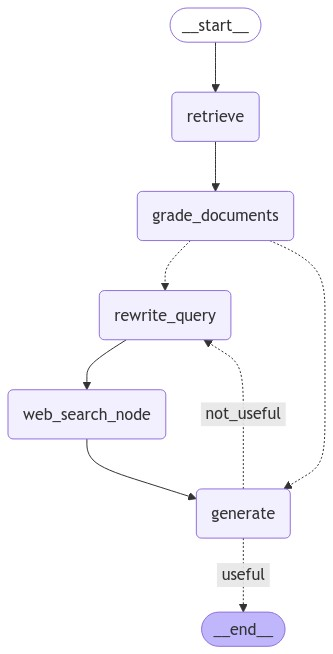

In [64]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [53]:
%%time
res = app.invoke({"input": "What's the temperature in London?"})
res

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---
CPU times: user 207 ms, sys: 8.84 ms, total: 216 ms
Wall time: 4.68 s


{'input': "What's the temperature in London?",
 'generation': 'The temperature in London is 18°C.',
 'web_search': 'No',
 'documents': [Document(metadata={'city': 'London', 'temperature': '18°C°C', 'weather': 'drizzle', 'climate': 'temperate maritime'}, page_content='Weather is drizzle and Climate is temperate maritime')]}

In [54]:
%%time
res = app.invoke({"input": "What's the temperature in Fort Worth?"})
res

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---ASSESS GRADED DOCUMENTS---
---DECISION: NONE OF THE DOCUMENTS ARE RELEVANT TO QUERY, REWRITE QUERY---
---REWRITE QUERY---
---modified_query: Current temperature in Fort Worth, Texas---
---WEB SEARCH---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION DOES NOT ANSWERS QUESTION---
---REWRITE QUERY---
---modified_query: "Fort Worth Texas current weather temperature"---
---WEB SEARCH---
---GENERATE---
---CHECK WHETHER GENERATION ANSWERS QUESTION---
---DECISION: GENERATION ANSWERS QUESTION---
CPU times: user 265 ms, sys: 7.65 ms, total: 273 ms
Wall time: 15.7 s


{'input': '"Fort Worth Texas current weather temperature"',
 'generation': 'According to the provided context, the current weather temperature in Fort Worth, Texas is 69.1°F (20.6°C).',
 'web_search': 'Yes',
 'documents': [Document(metadata={}, page_content='Slight ChanceT-storms thenT-stormsLikely\nHigh: 79 °F\nThursdayNight\nT-stormsLikely thenShowersLikely\nLow: 59 °F\nFriday\nShowersLikely\nHigh: 67 °F\nFridayNight\nChanceT-storms\nLow: 54 °F\nSaturday\nSlight ChanceT-storms thenChanceShowers\nHigh: 67 °F\nSaturdayNight\nChanceShowers\nLow: 54 °F\nSunday\n Partly Cloudy\n79°F\n26°C\nMore Information:\nLocal Forecast OfficeMore Local Wx3 Day HistoryMobile WeatherHourly Weather Forecast\nDallas / Fort Worth International Airport TX\nThisAfternoon\nMostly Sunny\nHigh: 81 °F\nTonight\n Slight ChanceShowers\nHigh: 68 °F\nDetailed Forecast\nAdditional Forecasts and Information\nZone Area Forecast for Dallas County, TX\nAdditional Resources\nHigh Temperature\nChance of Precipitation NWS\n

In [55]:
print(res['documents'][0].page_content)

Slight ChanceT-storms thenT-stormsLikely
High: 79 °F
ThursdayNight
T-stormsLikely thenShowersLikely
Low: 59 °F
Friday
ShowersLikely
High: 67 °F
FridayNight
ChanceT-storms
Low: 54 °F
Saturday
Slight ChanceT-storms thenChanceShowers
High: 67 °F
SaturdayNight
ChanceShowers
Low: 54 °F
Sunday
 Partly Cloudy
79°F
26°C
More Information:
Local Forecast OfficeMore Local Wx3 Day HistoryMobile WeatherHourly Weather Forecast
Dallas / Fort Worth International Airport TX
ThisAfternoon
Mostly Sunny
High: 81 °F
Tonight
 Slight ChanceShowers
High: 68 °F
Detailed Forecast
Additional Forecasts and Information
Zone Area Forecast for Dallas County, TX
Additional Resources
High Temperature
Chance of Precipitation NWS
All NOAA
Your local forecast office is
Winter Storm Developing in the Central U.S. with Areas of Heavy Snow, Severe Thunderstorms, and Fire Weather
A winter storm developing across the central Rockies today will spread heavy snow across the area, including the Denver Metro, through Friday, with

In [29]:
qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.\

{context}"""

qa_prompt = ChatPromptTemplate.from_messages([("system", qa_system_prompt), MessagesPlaceholder("chat_history"),
                                              ("human", "{input}")])

question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

In [54]:
chat_history = []

In [55]:
question = "Which cities have temperate climate?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history += [HumanMessage(content=question), ai_msg_1["answer"]]

In [56]:
ai_msg_1

{'input': 'Which cities have temperate climate?',
 'chat_history': [HumanMessage(content='Which cities have temperate climate?', additional_kwargs={}, response_metadata={}),
  'The cities with a temperate climate are Warsaw, New York, and Paris. All three cities have a temperate climate.'],
 'context': [Document(metadata={'city': 'Warsaw', 'temperature': 16, 'weather': 'overcast', 'climate': 'temperate'}, page_content='For city Warsaw, Temperature is 16°C, Weather is overcast and Climate is temperate'),
  Document(metadata={'city': 'New York', 'temperature': 22, 'weather': 'sunny', 'climate': 'temperate'}, page_content='For city New York, Temperature is 22°C, Weather is sunny and Climate is temperate'),
  Document(metadata={'city': 'Paris', 'temperature': 21, 'weather': 'partly sunny', 'climate': 'temperate'}, page_content='For city Paris, Temperature is 21°C, Weather is partly sunny and Climate is temperate')],
 'answer': 'The cities with a temperate climate are Warsaw, New York, and 

In [57]:
chat_history

[HumanMessage(content='Which cities have temperate climate?', additional_kwargs={}, response_metadata={}),
 'The cities with a temperate climate are Warsaw, New York, and Paris. All three cities have a temperate climate.']

In [59]:
second_question = "Where is it hottest?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})
chat_history += [HumanMessage(content=second_question), ai_msg_2["answer"]]

In [60]:
ai_msg_2

{'input': 'Where is it hottest?',
 'chat_history': [HumanMessage(content='Which cities have temperate climate?', additional_kwargs={}, response_metadata={}),
  'The cities with a temperate climate are Warsaw, New York, and Paris. All three cities have a temperate climate.',
  HumanMessage(content='Where is it hottest?', additional_kwargs={}, response_metadata={}),
  "I don't know, as there is no information provided about temperature comparisons between the cities."],
 'context': [],
 'answer': "I don't know, as there is no information provided about temperature comparisons between the cities."}

In [61]:
chat_history

[HumanMessage(content='Which cities have temperate climate?', additional_kwargs={}, response_metadata={}),
 'The cities with a temperate climate are Warsaw, New York, and Paris. All three cities have a temperate climate.',
 HumanMessage(content='Where is it hottest?', additional_kwargs={}, response_metadata={}),
 "I don't know, as there is no information provided about temperature comparisons between the cities."]